# Week4授業課題 信用情報を学習しよう



# 課題の目的

- 実データに近いものの学習推定を行う

# 信用情報

Week3でEDAを行ったKaggleの Home Credit Default Risk コンペティションの学習および推定を行います。データはWeek3でEDAを行ったものを使用してください。

[Home Credit Default Risk | Kaggle](https://www.kaggle.com/c/home-credit-default-risk)

# 【問題1】パイプラインの作成

授業前課題で行ったことを参考に、学習し推定結果を出すまでの一連の流れを行ってください。

テストデータに対して推定を行い、それをKaggleに提出してみましょう。この段階では高い精度を出す必要はありません。

# 方向性：パイプラインが動くことを確認する

1. データの前処理までは手作業で実施

   - どの変数を説明変数に用いるか？
   - 前処理する
   - EDAする（ひとまずint型、欠損値なしのみで実施） → パイプライン化する？
   - classifierのフィッティング、予測
   - スコアリングをまとめる
   
   - 学習・推計 ： パイプライン化


2. 前処理したデータを用いた推計はパイプラインで実行

In [1]:
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


from matplotlib import pyplot as plt
from matplotlib import cm

import seaborn as sns

%matplotlib inline

In [2]:
# データの読み込み
df_train = pd.read_csv("application_train.csv")
df_test = pd.read_csv("application_test.csv")

# df_train.info()

In [3]:
# 欠損値は消す
df_train = df_train.loc[:, ['EXT_SOURCE_1',  'EXT_SOURCE_2',
                                            'EXT_SOURCE_3', 'TARGET']].dropna()
df_test = df_train.loc[:, ['EXT_SOURCE_1',  'EXT_SOURCE_2',
                                            'EXT_SOURCE_3', 'TARGET']].dropna()

# EXT_SOURCEシリーズに着目して抽出
X_train = df_train.loc[:, ['EXT_SOURCE_1',  'EXT_SOURCE_2', 'EXT_SOURCE_3']].values
y_train = df_train.TARGET.values
X_test = df_test.loc[:, ['EXT_SOURCE_1',  'EXT_SOURCE_2', 'EXT_SOURCE_3']].values
y_test = df_test.TARGET.values

In [4]:
from sklearn import metrics
scaler = StandardScaler()

# 学習用データの最大値、最小値、平均、標準偏差、傾き...などの統計を取得
scaler.fit(X_train)

# 統計に基づき各データを書き換え
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 最近傍法
neigh = KNeighborsClassifier()

# 学習用データから学習
neigh.fit(X_train, y_train.reshape(-1))

y_pred = neigh.predict(X_test)

print('accuracy : {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('precision : {}'.format(metrics.precision_score(y_test, y_pred)))
print('recall : {}'.format(metrics.recall_score(y_test, y_pred)))
print('f値 : {}'.format(metrics.f1_score(y_test, y_pred)))
print(metrics.confusion_matrix(y_test, y_pred))

accuracy : 0.9303579738842402
precision : 0.6253424657534247
recall : 0.11415353838459615
f値 : 0.19306407274265172
[[101044    547]
 [  7085    913]]


0.5543846015790252


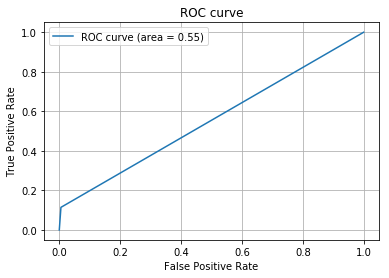

In [5]:
# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

print(auc)
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

# sns.pairplot(pd.concat([X_EX, y], axis=1 ), hue="TARGET")

# 【問題2】指標値の関数作成

このコンペティションでは提出した確率から指標値 AUC が計算され、それで順位が決まります。（Evaluationのページ参照）

- Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

https://oku.edu.mie-u.ac.jp/~okumura/stat/ROC.html

http://www.randpy.tokyo/entry/roc_auc

In [7]:
from sklearn import metrics

def calc_auc(y_test,y_pred):
    """
    検証用・予測した目的変数からAUCを計算する関数
    
    Parameters
    ----------------
    y_test : ndarrary 検証用目的変数
    y_pred : ndarrary 予測した目的変数 
    Return
    ----------------
    auc : float AUC
    tpr : float　真陽性率
    fpr : float　偽陽性率
    
    スコア
    """
    # FPR, TPR(, しきい値) を算出
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

    # auc算出
    auc = metrics.auc(fpr, tpr)
    
    return auc, tpr, fpr

In [7]:
auc, tpr, fpr = calc_auc(y_test, y_pred)
print(auc)
print(tpr[1])
print(fpr[1])

0.5543846015790252
0.11415353838459615
0.005384335226545659


# 【問題3】前処理・Feature Engineering・学習
* 精度を上げるために前処理・Feature Engineeringを行う  
week3で重要度の高かったものから試してみる  
提出が必要なので、検証データを使う+欠損の削除はやらない方針で

In [46]:
# 訓練データ
df_train = pd.read_csv('application_train.csv')

# 説明変数(week3のeda結果より抜粋)
X = df_train.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                                 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']]

# 欠損を中央値で埋め、warnが出るので、変換 int to float
X = X.fillna(X.median()).astype('float')

# 目的変数
y = df_train.loc[:, 'TARGET']

# 分割
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [47]:
from sklearn import metrics
scaler = StandardScaler()

# 学習用データの最大値、最小値、平均、標準偏差、傾き...などの統計を取得
scaler.fit(X_train)

# 統計に基づき各データを書き換え
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 最近傍法
neigh = KNeighborsClassifier()

# 学習用データから学習
neigh.fit(X_train, y_train)

# 予測
y_pred = neigh.predict(X_test)

# 本筋とそれるけど、閾値も動かしながら出力
for i in np.arange(0.1, 1, 0.1):
    y_pred = (neigh.predict_proba(X_test)[:, 1] > i).astype(int)
    auc, tpr, fpr = calc_auc(y_test, y_pred)
    print(i)
    print('auc : ' + str(auc))

0.1
auc : 0.5870746536601991
0.2
auc : 0.5510387771497275
0.30000000000000004
auc : 0.5510387771497275
0.4
auc : 0.5178123155676112
0.5
auc : 0.5178123155676112
0.6
auc : 0.5031374897522326
0.7000000000000001
auc : 0.5031374897522326
0.8
auc : 0.5001191108704222
0.9
auc : 0.5001191108704222


閾値デフォルトの0.5で下がってしまってる気がする、、  
ので、問題1の特徴量に戻して再実施

In [48]:
X = X.drop(['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH'], axis=1)
y = df_train['TARGET']

# 分割
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [49]:
from sklearn import metrics
scaler = StandardScaler()

# 学習用データの最大値、最小値、平均、標準偏差、傾き...などの統計を取得
scaler.fit(X_train)

# 統計に基づき各データを書き換え
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 最近傍法
neigh = KNeighborsClassifier()

# 学習用データから学習
neigh.fit(X_train, y_train)

# 予測
y_pred = neigh.predict(X_test)


for i in np.arange(0.1, 1, 0.1):
    y_pred = (neigh.predict_proba(X_test)[:, 1] > i).astype(int)
    auc, tpr, fpr = calc_auc(y_test, y_pred)
    print(i)
    print('auc : ' + str(auc))

0.1
auc : 0.5883791452330427
0.2
auc : 0.5473952429466856
0.30000000000000004
auc : 0.5473952429466856
0.4
auc : 0.5155130767774809
0.5
auc : 0.5155130767774809
0.6
auc : 0.502440708641271
0.7000000000000001
auc : 0.502440708641271
0.8
auc : 0.5004838557360795
0.9
auc : 0.5004838557360795


より下がってる。。  
一番最初の特徴量に戻して平均代入法で実施

In [50]:
# 訓練データ
df_train = pd.read_csv('application_train.csv')

# 説明変数(week3のeda結果より抜粋)
X = df_train.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                                 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']]

# 欠損を平均値で埋め、warnが出るので、変換 int to float
X = X.fillna(X.mean()).astype('float')

# 目的変数
y = df_train.loc[:, 'TARGET']

# 分割
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [51]:
from sklearn import metrics
scaler = StandardScaler()

# 学習用データの最大値、最小値、平均、標準偏差、傾き...などの統計を取得
scaler.fit(X_train)

# 統計に基づき各データを書き換え
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 最近傍法
neigh = KNeighborsClassifier()

# 学習用データから学習
neigh.fit(X_train, y_train)

# 予測
y_pred = neigh.predict(X_test)


for i in np.arange(0.1, 1, 0.1):
    y_pred = (neigh.predict_proba(X_test)[:, 1] > i).astype(int)
    auc, tpr, fpr = calc_auc(y_test, y_pred)
    print(i)
    print('auc : ' + str(auc))

0.1
auc : 0.5891698140953954
0.2
auc : 0.5481937117282546
0.30000000000000004
auc : 0.5481937117282546
0.4
auc : 0.5155221096543515
0.5
auc : 0.5155221096543515
0.6
auc : 0.5037888900300607
0.7000000000000001
auc : 0.5037888900300607
0.8
auc : 0.5005199935281393
0.9
auc : 0.5005199935281393


auc : 0.5891698140953954


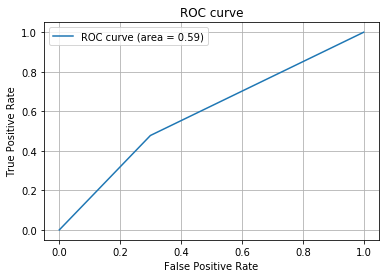

In [52]:
y_pred = (neigh.predict_proba(X_test)[:, 1] > 0.1).astype(int)
auc, tpr, fpr = calc_auc(y_test, y_pred)
print('auc : ' + str(auc))

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

かなり微妙な数値だけど一番マシっぽいので、これで提出。。。

In [55]:
df_test = pd.read_csv("application_test.csv")

# 説明変数(week3のeda結果より抜粋)
X_test = df_test.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                                         'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']]

# 欠損を平均値で埋め、warnが出るので、変換 int to float
X_test = X_test.fillna(X_test.mean())

# 予測
y_pred = (neigh.predict_proba(X_test)[:, 1] > 0.1).astype(int)

# 提出用
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_pred})

In [61]:
from datetime import datetime

# タイムスタンプ作成
time_stamp = datetime.now().strftime('%Y%m%d%H%M')
submission.to_csv('home_credit_' + time_stamp + '.csv', index=False)

submitしたらPrivate・Public Score共に0.5になってしまったので、どこか間違ってそう、、  
アプローチを変えてみる まずはモデルから、lgbmというワードが出てたので使ってみる  
決定木の勾配ブースティング?のフレームワークらしい  
欠損値も自動で保管してくれる

In [5]:
import lightgbm as lgb
import numpy as np
import pandas as pd

In [15]:
from sklearn.model_selection import train_test_split
# 訓練データ
df_train = pd.read_csv('application_train.csv')

# 説明変数(week3のeda結果より抜粋)
X = df_train.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                                         'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']]
# 目的変数
y = df_train.loc[:, 'TARGET']


# 学習用、検証用データに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y)


# インスタンス化
lgbc = lgb.LGBMClassifier()

# 学習
lgbc.fit(X, y)


for i in np.arange(0.1, 1, 0.1):
    y_pred = (lgbc.predict_proba(X_test)[:, 1] > i).astype(int)
    auc, tpr, fpr = calc_auc(y_test, y_pred)
    print(i)
    print('auc : ' + str(auc))

0.1
auc : 0.6828264158406426
0.2
auc : 0.6011975708478816
0.30000000000000004
auc : 0.541631097517283
0.4
auc : 0.5155775727463416
0.5
auc : 0.5039408186274337
0.6
auc : 0.500606279788836
0.7000000000000001
auc : 0.5
0.8
auc : 0.5
0.9
auc : 0.5


ちょっと上がったので、もう一回出してみる

In [16]:
from datetime import datetime

df_test = pd.read_csv("application_test.csv")

# 説明変数(week3のeda結果より抜粋)
X_test = df_test.loc[:, ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                                         'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_BIRTH']]

# 予測
y_pred = (lgbc.predict_proba(X_test)[:, 1] > 0.1).astype(int)

# 提出用
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_pred})



# タイムスタンプ作成
time_stamp = datetime.now().strftime('%Y%m%d%H%M')
submission.to_csv('home_credit_' + time_stamp + '.csv', index=False)

Private 0.64935
Public 0.64566
の結果になった。